Implement RBM for movie ratings.

In [1]:
import os 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import pandas as pd
from scipy.sparse import lil_matrix, csr_matrix, save_npz, load_npz
from datetime import datetime

In [8]:
# write our own one hot encoder 
# 1. inputs are not integers, they are fractional values
# 2. inputs are 2-D,  we want output to be 3-D
# so cannot use sklearn's one hot encoder 
def one_hot_encode(X, K):
    # X is N x D 
    # expect output to be N x D x K 
    N, D = X.shape
    # output
    Y = np.zeros((N, D, K))
    # loop through NONZERO elements in X and update Y 
    for n, d in zip(*X.nonzero()):
        # ratings originally ranges in [0.5, 5], so k ranges from 0 - 9 
        k = int(X[n, d] * 2 - 1)
        Y[n, d, k] = 1
    return Y 


def one_hot_mask(X, K):
    N, D = X.shape
    Y = np.zeros((N, D, K))
    # update vector of len K to be 1 only when the ratings are not missing 
    for n, d in zip(*X.nonzero()):
        Y[n, d, :] = 1 
    return Y 
            

In [9]:


# ratings 1 - 10
one_to_ten = np.arange(10) + 1 # [1, 2, 3, ..., 10]
# take the average ratings as final prediction 
def convert_probs_to_ratings(probs):
    # probs is N x D x K
    # output is N x D matrix of predicted ratings
    # N, D, K = probs.shape
    # out = np.zeros((N, D))
    # each predicted rating is a weighted average using the probabilities
    # for n in range(N):
    #     for d in range(D):
    #         out[n,d] = probs[n,d].dot(one_to_ten) / 2
    # return out
    # convert to ratings in 0 - 5 
    return probs.dot(one_to_ten) / 2

In [10]:
# define customized dot function for 3-D tensors 

# N: number of samples (users)
# D: number of movies 
# K: number of possible ratings 
# M: number of hidden units 

# Compute N x M of WV over D and K dimensions for p(h | v)
# it also takes cares of multiplication of Vb
def dot1(V, W):
    # V is N x D x K (visible units)
    # W is D x K x M (weights)
    # axes[0] defines what dimension to sum over in the first tensor
    # axes[1] defines what corresponding dimension to sum over in the second tnesor 
    return tf.tensordot(V, W, axes = [[1, 2], [0, 1]])

    


# Compute N x D x K of HW over M dimensions for p (v | h)
def dot2(H, W):
    # H is N x M (batch of hiddens)
    # W is D x K x M (weights transposed)
    return tf.tensordot(H, W, axes = [[1], [2]])


In [13]:
# RBM training 
# N: number of samples (users)
# D: number of movies 
# K: number of possible ratings 
# M: number of hidden units 
class RBM(object):
    def __init__(self, D, M, K):
        self.D = D 
        self.M = M 
        self.K = K 
        # build model 
        self.build(D, M, K)
    def build(self, D, M, K):
        # initialization 
        self.W = tf.Variable(tf.random_normal(shape = (D, K, M)) * np.sqrt(2.0 / M))
        self.c = tf.Variable(np.zeros(M).astype(np.float32))
        self.b = tf.Variable(np.zeros((D, K)).astype(np.float32))
        
        # input and mask 
        self.X_input = tf.placeholder(tf.float32, shape = (None, D, K))
        self.mask = tf.placeholder(tf.float32, shape = (None, D, K))
        
        # conditional probabilities p(h | v), see equations 54 in notes 
        V = self.X_input 
        self.p_h_given_v = tf.nn.sigmoid(dot1(V, self.W) + self.c)
        
        # draw a sample from p(h | v)
        alpha = tf.random_uniform(shape = tf.shape(self.p_h_given_v))
        H = tf.to_float(alpha < self.p_h_given_v)
        
        # draw a sample from p(v | h) with softmax 
        logits = dot2(H, self.W) + self.b
        #  distributions 
        # https://www.tensorflow.org/api_docs/python/tf/distributions/Categorical
        dist = tf.distributions.Categorical(logits = logits) # log probs 
        # draw sample 
        X_sample = dist.sample() # N x D 
        # convert sample to N x D x K tensor 
        X_sample = tf.one_hot(X_sample, depth = K)
        
        # remove samples drawn for missing ratings 
        X_sample = X_sample * self.mask
        
        # objective function: free energy of input - free energy of the sample 
        objective = tf.reduce_mean(self.free_energy(self.X_input)) - tf.reduce_mean(self.free_energy(X_sample))
        self.train_optimizer = tf.train.AdamOptimizer(1e-2).minimize(objective)
        
        # check cost function 
        logits = self.forward_logits(self.X_input)
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.X_input, logits = logits))
        
        # output 
        self.output_visible = self.forward_output(self.X_input)
        
        init = tf.global_variables_initializer()
        self.session = tf.Session()
        self.session.run(init)
        
    def fit(self, X, mask, X_test, mask_test, epochs = 15, batch_size = 256, show_fig = True):
        N, D = X.shape
        n_batches = N // batch_size + 1 
        
        costs = []
        test_costs = []
        
        for i in range(epochs):
            t0 = datetime.now()
            print('epoch: ', i)
            # shuffle the same way for X, mask, X_test, mask_test 
            X, mask, X_test, mask_test = shuffle(X, mask, X_test, mask_test)
            for j in range(n_batches):
                upper_limit = min((j + 1) * batch_size, N)
                # convert to arrays for faster computation 
                x = X[j * batch_size : upper_limit].toarray()
                m = mask[j * batch_size : upper_limit].toarray()
                
                # convert x to one hot form 
                batch_one_hot = one_hot_encode(x, self.K)
                m = one_hot_mask(m, self.K)
                _, c = self.session.run((self.train_optimizer, self.cost), 
                                       feed_dict = {self.X_input: batch_one_hot, self.mask: m})
                
                if j % 200 == 0:
                    print(j / n_batches, 'batches, cost is', c)
                
            print('Time spent:', datetime.now() - t0)
            
            # compute train and test costs 
            sse, test_sse = 0, 0 
            n, test_n = 0, 0 
            for j in range(n_batches):
                upper_limit = min((j + 1) * batch_size, N)
                x = X[j * batch_size : upper_limit].toarray()
                m = mask[j * batch_size : upper_limit].toarray()
                
                # convert visible input to one hot form 
                xoh = one_hot_encode(x, self.K)
                probs = self.get_visible(xoh)
                xhat = convert_probs_to_ratings(probs)
                sse += (m * (xhat - x) * (xhat - x)).sum()
                n += m.sum()
                
                # test sse, only use the predictions in trainings set which have real ratings listed in test set  
                x_test = X_test[j * batch_size : upper_limit].toarray()
                m_test = mask_test[j * batch_size : upper_limit].toarray()
                test_sse += (m_test * (xhat - x_test) * (xhat - x_test)).sum()
                test_n += m_test.sum()
                
                cost_train = sse / n 
                cost_test = test_sse / test_n
                
                print('train mse: ', cost_train)
                print('test mse: ', cost_test)
                
                costs.append(cost_train)
                test_costs.append(cost_test)
            if show_fig:
                plt.plot(costs, label = 'train mse')
                plt.plot(test_costs, label = 'test mse')
                plt.legend()
                plt.show()
                
    def free_energy(self, V):
        first_term = -tf.reduce_sum(dot1(V, self.b))
        second_term = -tf.reduce_sum(
            # tf.log(1 + tf.exp(tf.matmul(V, self.W) + self.c)),
            tf.nn.softplus(dot1(V, self.W) + self.c),
            axis = 1
        )
        return first_term + second_term

    def forward_hidden(self, X):
        return tf.nn.sigmoid(dot1(X, self.W) + self.c)

    def forward_logits(self, X):
        Z = self.forward_hidden(X)
        return dot2(Z, self.W) + self.b

    def forward_output(self, X):
        return tf.nn.softmax(self.forward_logits(X))

    def transform(self, X):
        # accepts and returns a real numpy array
        # unlike forward_hidden and forward_output
        # which deal with tensorflow variables
        return self.session.run(self.p_h_given_v, feed_dict={self.X_input: X})

    def get_visible(self, X):
        return self.session.run(self.output_visible, feed_dict={self.X_input: X})            
                
        

epoch:  0
0.0 batches, cost is 0.53204113
Time spent: 0:00:15.397166
train mse:  0.7715918132577252
test mse:  0.7796931706240996
train mse:  0.7638928561098919
test mse:  0.7694766593462665
train mse:  0.7607309295197731
test mse:  0.7740656027230294
train mse:  0.770365467582784
test mse:  0.7812130543497129
train mse:  0.7597461384649729
test mse:  0.7683047417562909
train mse:  0.7563959498187453
test mse:  0.7655439532262073
train mse:  0.7557503487575006
test mse:  0.7677093404340449
train mse:  0.7582076609739079
test mse:  0.7705999512728604
train mse:  0.7582145111653764
test mse:  0.7698814032896072
train mse:  0.7603395585358577
test mse:  0.772640308988087
train mse:  0.7617501855015446
test mse:  0.7742916801730674
train mse:  0.7637532100540785
test mse:  0.7755568800429083
train mse:  0.7607054229810485
test mse:  0.7726459394100789
train mse:  0.7605992369385493
test mse:  0.7716503740306855
train mse:  0.7596504820135558
test mse:  0.7705641278178377
train mse:  0.7633

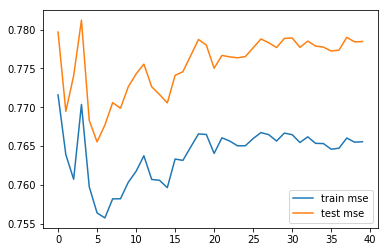

epoch:  1
0.0 batches, cost is 0.376057
Time spent: 0:00:15.842929
train mse:  0.7131031645925298
test mse:  0.7255714025565616
train mse:  0.705850815909058
test mse:  0.7234723269186404
train mse:  0.7072389510556704
test mse:  0.7206896535313586
train mse:  0.7065312205590307
test mse:  0.7234715863458719
train mse:  0.7018721950380901
test mse:  0.7175353529374416
train mse:  0.7015393214258983
test mse:  0.7164130251558756
train mse:  0.6979498109950889
test mse:  0.7123537799890762
train mse:  0.6935831163539672
test mse:  0.7093184994163193
train mse:  0.6963549254739988
test mse:  0.7116215755064432
train mse:  0.7002905289378307
test mse:  0.7148816639129077
train mse:  0.6997061910728397
test mse:  0.7137864553341708
train mse:  0.6975088119435265
test mse:  0.7114071241628847
train mse:  0.6969690575130678
test mse:  0.7109778805258539
train mse:  0.6999988626593349
test mse:  0.7142388185593501
train mse:  0.6995838414536527
test mse:  0.7138405656458936
train mse:  0.69925

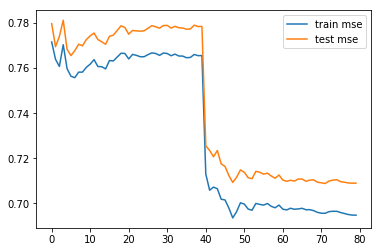

epoch:  2
0.0 batches, cost is 0.3426664
Time spent: 0:00:16.121815
train mse:  0.6383841356774841
test mse:  0.653268865912465
train mse:  0.6657278099359819
test mse:  0.6798291660365732
train mse:  0.6746000163452537
test mse:  0.6877870958838834
train mse:  0.6791934457530638
test mse:  0.6917761312090492
train mse:  0.6774307909101823
test mse:  0.6898815712455821
train mse:  0.6778738183281829
test mse:  0.6919371839982057
train mse:  0.6775013083369583
test mse:  0.6900808811345753
train mse:  0.6751221951848954
test mse:  0.6891636036205252
train mse:  0.6756729561215213
test mse:  0.6904145285626911
train mse:  0.6736457429719935
test mse:  0.6878356615025896
train mse:  0.67238247447151
test mse:  0.6876251809177463
train mse:  0.6713967910885633
test mse:  0.6860435404879328
train mse:  0.6687711203717317
test mse:  0.6829026108101174
train mse:  0.6715157540742699
test mse:  0.6852822146509009
train mse:  0.6722197510531966
test mse:  0.6867316254621877
train mse:  0.670119

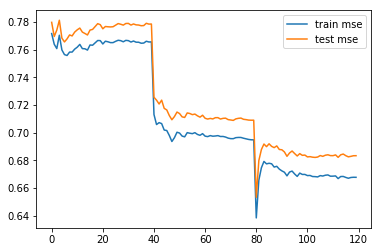

epoch:  3
0.0 batches, cost is 0.35105017
Time spent: 0:00:16.527411
train mse:  0.6301009053694792
test mse:  0.6429557753744715
train mse:  0.6385869973664484
test mse:  0.6590887984576002
train mse:  0.6394718568859223
test mse:  0.6566726326215064
train mse:  0.6389040581009752
test mse:  0.6574174146047096
train mse:  0.6431686238531445
test mse:  0.6593988316454871
train mse:  0.6423591694280767
test mse:  0.6597353319850134
train mse:  0.6436537383070017
test mse:  0.6624390291451973
train mse:  0.6497173844377718
test mse:  0.6675848956113631
train mse:  0.6492600539036312
test mse:  0.6673550643101395
train mse:  0.6468170555811583
test mse:  0.6649341144582652
train mse:  0.6483021726724346
test mse:  0.6650493608231324
train mse:  0.6524099503480782
test mse:  0.6690084079475228
train mse:  0.6553073087261565
test mse:  0.6711884450140223
train mse:  0.6543982095500669
test mse:  0.6703409055146248
train mse:  0.652773785800731
test mse:  0.668998313611379
train mse:  0.6529

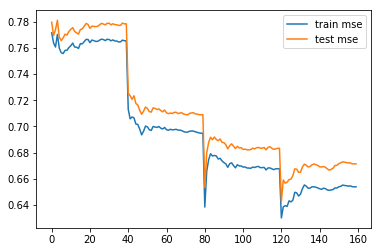

epoch:  4
0.0 batches, cost is 0.3470583
Time spent: 0:00:16.168581
train mse:  0.6281077128053576
test mse:  0.6538314257587032
train mse:  0.6473666374524657
test mse:  0.6650581904011975
train mse:  0.6435840405132326
test mse:  0.6609430524707346
train mse:  0.6480933805522432
test mse:  0.6678917253054236
train mse:  0.6477301158674514
test mse:  0.6684393107063833
train mse:  0.6468114784662168
test mse:  0.6669507830402825
train mse:  0.6480593063321209
test mse:  0.6689396827231592
train mse:  0.6468359850274854
test mse:  0.666939385414772
train mse:  0.6465055635023695
test mse:  0.6659825416712268
train mse:  0.6457455399316603
test mse:  0.6652933374402866
train mse:  0.647839662433483
test mse:  0.667581742418919
train mse:  0.6482156593950247
test mse:  0.6688441013666874
train mse:  0.6472821193320628
test mse:  0.6682035028598305
train mse:  0.6467908742167309
test mse:  0.6666352145902487
train mse:  0.6452555681382462
test mse:  0.6649175127161101
train mse:  0.643793

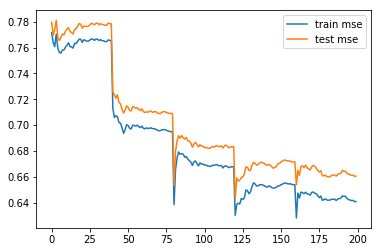

epoch:  5
0.0 batches, cost is 0.3291506
Time spent: 0:00:16.402277
train mse:  0.6156037540899401
test mse:  0.631840398707951
train mse:  0.6195806162411326
test mse:  0.6359760789677644
train mse:  0.6303180384688524
test mse:  0.6468824145418434
train mse:  0.6464449265821601
test mse:  0.6633712757181599
train mse:  0.6371336958777217
test mse:  0.653043773816565
train mse:  0.6387016228578613
test mse:  0.6554035305125914
train mse:  0.6352866057108701
test mse:  0.6526191632989903
train mse:  0.6366237211692757
test mse:  0.6550200818811989
train mse:  0.6355479789109145
test mse:  0.6536720311725942
train mse:  0.6338872157823559
test mse:  0.6530917196605243
train mse:  0.6331083016574671
test mse:  0.6523208546234309
train mse:  0.6326335971112022
test mse:  0.6530631315063791
train mse:  0.6313212768383776
test mse:  0.6512802703009364
train mse:  0.6306002050104053
test mse:  0.6504565621040016
train mse:  0.6286962541692896
test mse:  0.6483127910675568
train mse:  0.62857

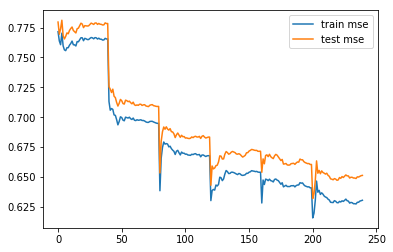

epoch:  6
0.0 batches, cost is 0.33714694
Time spent: 0:00:16.129408
train mse:  0.6166130618704092
test mse:  0.6360164460164566
train mse:  0.6278456772699866
test mse:  0.6483328430370939
train mse:  0.6258446195283535
test mse:  0.6436756068657976
train mse:  0.6189483077137127
test mse:  0.6355317375363359
train mse:  0.6200789051311192
test mse:  0.6395311260701141
train mse:  0.6178341102842676
test mse:  0.6379264185943307
train mse:  0.6199161679801012
test mse:  0.6410201029286081
train mse:  0.6168924891918556
test mse:  0.6379220403007534
train mse:  0.6205240352774936
test mse:  0.6410331121242546
train mse:  0.6233293459080146
test mse:  0.6441023902494452
train mse:  0.6237882132415813
test mse:  0.6444420599445077
train mse:  0.624392448826722
test mse:  0.6447143701749676
train mse:  0.6228999987372276
test mse:  0.6444381733730261
train mse:  0.6246959756465043
test mse:  0.6464549793027246
train mse:  0.6248575875269912
test mse:  0.6471909399985931
train mse:  0.622

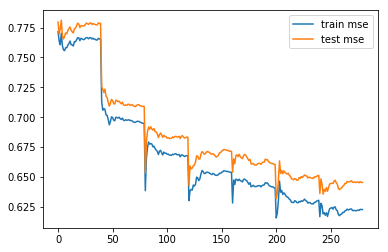

epoch:  7
0.0 batches, cost is 0.32172808
Time spent: 0:00:16.552117
train mse:  0.5956100977571677
test mse:  0.6226095007928181
train mse:  0.6098470062866833
test mse:  0.6396749519651961
train mse:  0.6124480948001502
test mse:  0.6393485003940127
train mse:  0.6109233582164322
test mse:  0.6359110374961997
train mse:  0.6092721585960269
test mse:  0.6322862623508471
train mse:  0.6082946227960156
test mse:  0.6309008227594879
train mse:  0.6089104004122283
test mse:  0.6300247697148706
train mse:  0.6078246577696735
test mse:  0.6284123310971731
train mse:  0.6089264528187308
test mse:  0.6300821408265067
train mse:  0.6103667640872881
test mse:  0.6326148830850714
train mse:  0.6117462634189699
test mse:  0.6331911293330136
train mse:  0.6120298213809049
test mse:  0.6329257759021026
train mse:  0.6138557114622454
test mse:  0.6350752623851896
train mse:  0.6142799153983118
test mse:  0.6356272279121064
train mse:  0.6139047752325716
test mse:  0.6353316057856302
train mse:  0.61

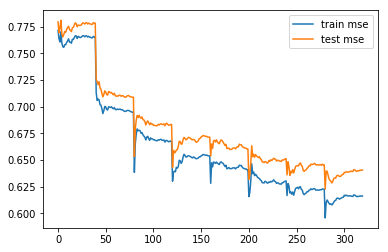

epoch:  8
0.0 batches, cost is 0.3359543
Time spent: 0:00:16.548159
train mse:  0.5990139366438693
test mse:  0.6241121954559116
train mse:  0.6092011042903223
test mse:  0.6285721520137854
train mse:  0.6024199270509659
test mse:  0.6251702331181528
train mse:  0.6062009688710767
test mse:  0.6272404165264684
train mse:  0.6140308189298297
test mse:  0.6336880065340091
train mse:  0.6076496636771382
test mse:  0.6258152615467194
train mse:  0.6052093952948594
test mse:  0.6234341698227474
train mse:  0.6049442792369328
test mse:  0.6247923249394282
train mse:  0.6072316303612605
test mse:  0.6283542451964839
train mse:  0.6040824947264415
test mse:  0.6256802819153161
train mse:  0.6036883183339191
test mse:  0.626008514804799
train mse:  0.606254867435553
test mse:  0.6293516850957738
train mse:  0.6050896340426425
test mse:  0.6276845979903038
train mse:  0.6055665791156896
test mse:  0.628183272333434
train mse:  0.6058866276518494
test mse:  0.6294634598765929
train mse:  0.608671

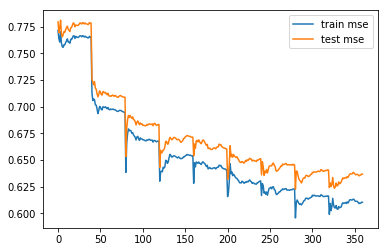

epoch:  9
0.0 batches, cost is 0.3381411
Time spent: 0:00:16.529184
train mse:  0.6615618276807023
test mse:  0.6815628257895036
train mse:  0.6460906108315813
test mse:  0.6710932294611096
train mse:  0.633739510252416
test mse:  0.6605855265127113
train mse:  0.6253249956199418
test mse:  0.6509431774761579
train mse:  0.6277568142245054
test mse:  0.6538768963498831
train mse:  0.6260959623441968
test mse:  0.6523461776474068
train mse:  0.6210342982474745
test mse:  0.6477486270322257
train mse:  0.6200356476824145
test mse:  0.6460282035063232
train mse:  0.622473044282581
test mse:  0.6481452832822476
train mse:  0.6207018267888115
test mse:  0.6474607590349952
train mse:  0.6189818700665026
test mse:  0.6454708760896943
train mse:  0.6184274209474098
test mse:  0.6458772104877872
train mse:  0.6167258736033479
test mse:  0.6448204807219634
train mse:  0.6154214070939411
test mse:  0.6422893667938772
train mse:  0.6142505250493342
test mse:  0.6408697992628178
train mse:  0.61505

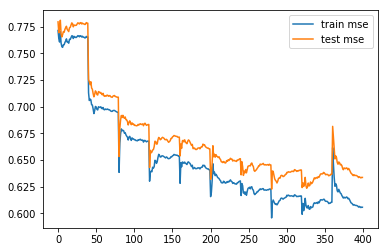

epoch:  10
0.0 batches, cost is 0.32029304
Time spent: 0:00:16.642136
train mse:  0.6082176235495498
test mse:  0.6291855214396668
train mse:  0.5905064968232848
test mse:  0.6170171712159334
train mse:  0.6045572385556283
test mse:  0.6293112434850628
train mse:  0.605127414841635
test mse:  0.6325078513529224
train mse:  0.6025926888357958
test mse:  0.6282556470601888
train mse:  0.6011160641326592
test mse:  0.6293184873409731
train mse:  0.6020904520424373
test mse:  0.6303577131557634
train mse:  0.6033389115641494
test mse:  0.6327834026773856
train mse:  0.6036147824131834
test mse:  0.6337780057706633
train mse:  0.605558790097003
test mse:  0.6344224999656203
train mse:  0.6036658322386227
test mse:  0.6327105157946061
train mse:  0.6019491921774109
test mse:  0.6307505539686395
train mse:  0.6023290657136324
test mse:  0.6318016269459574
train mse:  0.6022543715226645
test mse:  0.6316800904941647
train mse:  0.6005985849194433
test mse:  0.6288911239009973
train mse:  0.600

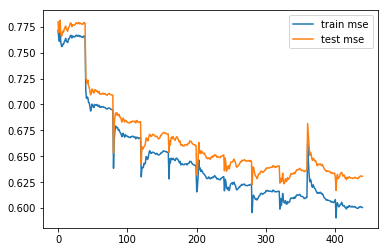

epoch:  11
0.0 batches, cost is 0.33741418
Time spent: 0:00:17.137658
train mse:  0.5919976574857021
test mse:  0.620752269438099
train mse:  0.5941316478432535
test mse:  0.6207779555023687
train mse:  0.605801760453593
test mse:  0.6310229977518181
train mse:  0.599881359474465
test mse:  0.6282022548540253
train mse:  0.6007230881766404
test mse:  0.6312537386505481
train mse:  0.6013742508561696
test mse:  0.6339050644263088
train mse:  0.5979823934791486
test mse:  0.6288802633432422
train mse:  0.593554721617591
test mse:  0.6243742052959
train mse:  0.5958537704310574
test mse:  0.6268766568817257
train mse:  0.597409893348008
test mse:  0.6300636549203544
train mse:  0.5971143678349032
test mse:  0.630069315660252
train mse:  0.5964559317713608
test mse:  0.6284553621029609
train mse:  0.5976299936885232
test mse:  0.6294267028404131
train mse:  0.598472319128061
test mse:  0.6307545473880741
train mse:  0.5974180702424838
test mse:  0.6293509668412207
train mse:  0.59868024905

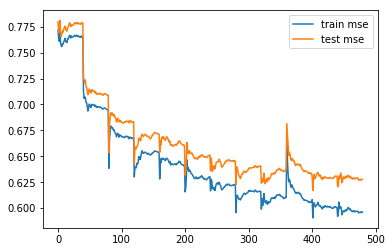

epoch:  12
0.0 batches, cost is 0.31309676
Time spent: 0:00:16.720509
train mse:  0.608700993024826
test mse:  0.6394883887721214
train mse:  0.6062053186267933
test mse:  0.6362715223746828
train mse:  0.5958264243165932
test mse:  0.6253995928253425
train mse:  0.5959990764369113
test mse:  0.6278060440527844
train mse:  0.5894472685040137
test mse:  0.6228384226217943
train mse:  0.5914148268046436
test mse:  0.6249943864210643
train mse:  0.5887954570716671
test mse:  0.6203512780155426
train mse:  0.5933314661561152
test mse:  0.625111896230177
train mse:  0.5945399753929586
test mse:  0.625700433430848
train mse:  0.5939459158385356
test mse:  0.6259696897853556
train mse:  0.5932178147386776
test mse:  0.6260217205966743
train mse:  0.5955048091254164
test mse:  0.6282712802459945
train mse:  0.5955512141082006
test mse:  0.6284005411862018
train mse:  0.597511934181596
test mse:  0.6301890625120381
train mse:  0.5975442537089766
test mse:  0.6307064112141967
train mse:  0.59514

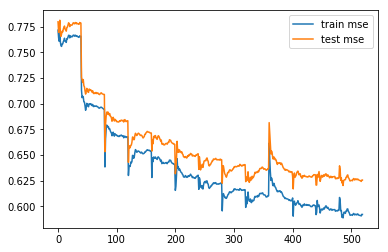

epoch:  13
0.0 batches, cost is 0.31597325
Time spent: 0:00:17.074698
train mse:  0.5637519162025904
test mse:  0.5969701430870612
train mse:  0.5759220549522264
test mse:  0.6180075919657375
train mse:  0.5871282928951458
test mse:  0.6243744924019927
train mse:  0.5914039317597855
test mse:  0.6283743589834087
train mse:  0.5919653023552841
test mse:  0.6313497743628067
train mse:  0.5886588874824638
test mse:  0.6254698577257294
train mse:  0.5882649514057398
test mse:  0.625454622057568
train mse:  0.5904555337340976
test mse:  0.6289551529122998
train mse:  0.5874216770674325
test mse:  0.6244478906060258
train mse:  0.5865480690729217
test mse:  0.6246751081013808
train mse:  0.5862295011632156
test mse:  0.6252033200333644
train mse:  0.5848351251561722
test mse:  0.6236908597676049
train mse:  0.5855399730339381
test mse:  0.6238642643685702
train mse:  0.5862800592146963
test mse:  0.6239997812886218
train mse:  0.5893158410735816
test mse:  0.6273881549235301
train mse:  0.58

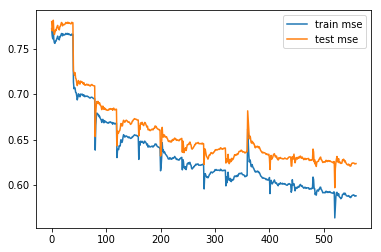

epoch:  14
0.0 batches, cost is 0.32057172
Time spent: 0:00:16.552639
train mse:  0.5961595760498338
test mse:  0.628804211426992
train mse:  0.580358566684238
test mse:  0.6120515028324462
train mse:  0.5692606154185612
test mse:  0.6027989454323592
train mse:  0.5739000752872685
test mse:  0.6081815223665831
train mse:  0.5795390891040149
test mse:  0.6130802239781841
train mse:  0.5827937252266314
test mse:  0.6194393164873208
train mse:  0.5850481475273748
test mse:  0.6229835679507103
train mse:  0.5862955876629856
test mse:  0.6243961993070191
train mse:  0.5851212353802737
test mse:  0.6230476409778727
train mse:  0.58262069201553
test mse:  0.6195145239386718
train mse:  0.5844951536351766
test mse:  0.6213624224195551
train mse:  0.584893483042383
test mse:  0.6214917465419021
train mse:  0.5860224677406104
test mse:  0.6221254508113692
train mse:  0.5893661843599185
test mse:  0.6250829820411404
train mse:  0.5892355340137805
test mse:  0.6245979398461535
train mse:  0.588204

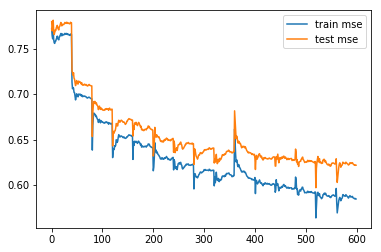

In [14]:
os.chdir(r'/home/qshan/Desktop/Repos/Big_Data_Projects/Recommender_System/data/ml-20m')

def main():
    A = load_npz("A_train.npz")
    A_test = load_npz("A_test.npz")
    mask = (A > 0) * 1.0
    mask_test = (A_test > 0) * 1.0

    N, M = A.shape
    rbm = RBM(M, 50, 10)
    rbm.fit(A, mask, A_test, mask_test)


if __name__ == '__main__':
    main()